# IMA204 Practical Session - Segmentation of medical images

## 0. Importations

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
import scipy
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


# PRINT VERSIONS
#print("os.__version__",os.__version__)
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("scipy.__version__",scipy.__version__)
print("cv2.__version__",cv2.__version__)
#print("glob.__version__",glob.__version__)

np.__version__ 1.26.4
matplotlib.__version__ 3.9.4
skimage.__version__ 0.24.0
scipy.__version__ 1.13.1
cv2.__version__ 4.6.0


## 1. General Pipeline Overview

1. **Preprocessing**: Enhance image contrast and reduce noise using regular filtering (e.g., histogram equalization and median filtering).  
2. **Segmentation**: Use k-means clustering and thresholding for initial segmentation.  
3. **Postprocessing**: Refine segmentation using morphological operations and connected components.  
4. **Evaluation**: Compare the segmentation results against ground truth using Dice coefficient and other quality metrics.  
5. **Automation**: Implement hyperparameter tuning and generalization to work on multiple examples without manual intervention.

In [103]:
# --- Helper Functions ---
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels



def histogram_stretching(img, new_min, new_max):
    """
    Perform histogram stretching on a grayscale image.
    """
    img = np.asarray(img, dtype=np.float32)
    old_min = np.min(img)
    old_max = np.max(img)

    if old_min == old_max:
        raise ValueError("Image has constant intensity. Histogram stretching is not applicable.")
    
    stretched_img = (img - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    stretched_img = np.clip(stretched_img, new_min, new_max)

    if np.issubdtype(img.dtype, np.integer):
        stretched_img = stretched_img.astype(np.uint8)
    
    return stretched_img


def calculate_dice(seg, gt):
    """
    Calculates the Dice coefficient.
    """
    intersection = np.sum((seg > 0) & (gt > 0))
    seg_nonzero = np.sum(seg > 0)
    gt_nonzero = np.sum(gt > 0)
    
    return 2 * intersection / (seg_nonzero + gt_nonzero)

## 2. Implementation of the Pipeline for the Abdominal CT

Here’s a concise description of the segmentation pipeline in bullet points:

- **Step 1: Preprocessing**
  - Enhance image contrast using adaptive histogram equalization.
  - Reduce noise with a median filter.

- **Step 2: K-Means Segmentation**
  - Apply k-means clustering to segment the image into `NBER_CLUSTERS` regions.

- **Step 3: Mean Intensity Calculation**
  - Calculate the mean pixel intensity for each k-means cluster.

- **Step 4: Target Label Selection**
  - Select the cluster label closest to a predefined target intensity.

- **Step 5: Binary Mask Generation**
  - Create a binary mask for the selected cluster.

- **Step 6: Postprocessing**
  - Smooth the binary mask using Gaussian filtering.
  - Remove small objects and fill small holes to clean up the mask.

- **Step 7: Connected Component Extraction**
  - Identify and analyze connected components in the cleaned mask.

- **Step 8: Morphological Closing**
  - Apply morphological closing to each connected component to smooth boundaries and fill small gaps.

- **Step 9: Component Filtering**
  - Filter connected components based on criteria like a minimum area and an almost circular shaped.

In [3]:
# --- Hyperparameters ---
RADIUS = 2                  # Radius for the morphological structuring element (used for basic morphology operations)
NBER_CLUSTERS = 4           # Number of clusters for k-means clustering (determines how the image is segmented)
TARGET_VALUE_THRESH = 150   # Intensity threshold to target specific pixel ranges for segmentation
GAUSSIAN_SIGMA = 3          # Sigma value for Gaussian smoothing (controls the level of blur applied to smooth edges)
SMOOTH_THRESH = 0.30        # Threshold for binarizing smoothed segmentation results
MIN_SIZE = 200              # Minimum size for connected components to be considered valid
AREA_THRESH = 50            # Minimum area threshold for removing small holes in segmentation
MEDIAN_SIZE = 5             # Size of the kernel for the median filter (used to reduce noise)
RADIUS_CLOSING = 30         # Radius for morphological closing (used to smooth the boundaries of connected components)
AREA_TOLERANCE = 0.25       # Tolerance for comparing the area of components to an ideal shape (e.g., a circle)
AREA_MIN = 1500             # Minimum area required for a component to be considered valid
#------------------------

In [4]:
def filter_components_abdCT(labels, numLabels, area_tolerance, area_min):
    """
    Filters connected components by their smoothness using circularity and how close the area is to 
    the area of a circle with the same perimeter.
    """
    filtered_labels = np.zeros_like(labels)

    for i in range(1, numLabels):  # Skip the background (index 0)
        
        component_mask = (labels == i).astype(np.uint8)

        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        external_area = cv2.contourArea(contours[0])
        perimeter = cv2.arcLength(contours[0], True)
        radius = perimeter / (2 * np.pi)
        circle_area = np.pi * radius ** 2
        
        if circle_area > 0:
            area_ratio = np.abs(1- external_area / circle_area)
        else:
            area_ratio = 1
            
        if area_ratio <= area_tolerance and external_area >= area_min:
            filtered_labels[labels == i] = i

    return filtered_labels

In [19]:
# --- Main Pipeline ---
def segmentation_pipeline_abdCT(img_test, img_seg_gt):
    """Processes a single example using the segmentation pipeline."""
    
    # Step 1 : Preprocessing with Contrast enhancement and noise reduction
    img_histeq = skimage.exposure.equalize_adapthist(img_test, clip_limit=0.03)
    img_filtered = ndimage.median_filter(img_histeq, size=MEDIAN_SIZE)
    

    # Step 2 : K-Means Segmentation
    seg_kmeans, seg_labels = my_kmeans(img_filtered, NBER_CLUSTERS)
    colormap = plt.get_cmap('nipy_spectral', NBER_CLUSTERS)

    # Step 3 : Compute mean pixel intensity under each k-means label
    img_label_means = np.empty(NBER_CLUSTERS)
    for i in range(NBER_CLUSTERS):
        img_label_mask = seg_labels == i
        img_label_mask = img_label_mask.astype('uint8')
        img_label_means[i] = cv2.mean(img_test, img_label_mask)[0]
     
    # Step 4 : Select label closest to target intensity 
    target_value = np.mean(img_test[img_test > TARGET_VALUE_THRESH])
    label_diffs = np.abs(img_label_means - target_value)
    selected_label = np.argmin(label_diffs)

    # Step 5: Generate binary mask for selected label
    img_label_select = (seg_labels == selected_label).astype('float64')

    # Step 6 : Postprocessing
    seg_smooth = gaussian(img_label_select, sigma=GAUSSIAN_SIGMA, preserve_range=True)
    seg_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(seg_smooth > SMOOTH_THRESH, 
                                        min_size=MIN_SIZE), 
        area_threshold=AREA_THRESH)
    
    # Step 7 : Extract connected components
    output = cv2.connectedComponentsWithStats(seg_clean.astype(np.uint8))
    (numLabels, labels, stats, centroids) = output
    
    # Step 8 : Morphological Closing
    img_closed = np.zeros_like(img_test)
    closed_components = np.zeros_like(img_test)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (RADIUS_CLOSING, RADIUS_CLOSING))

    for i in range(1, numLabels):  
        component_mask = (labels == i).astype(np.uint8)
        closed_component = cv2.morphologyEx(component_mask, cv2.MORPH_CLOSE, kernel)
        closed_components[closed_component == 1] = i
        img_closed[closed_component == 1] = 255
        
    # Step 9 : Component Filtering
    selected_components = filter_components_abdCT(closed_components, numLabels, AREA_TOLERANCE, AREA_MIN)
    img_output = np.zeros_like(labels, dtype=np.uint8)
    img_output[selected_components != 0] = 255
    
    # Step 10 : Evaluation
    dice_score = calculate_dice(img_output, img_seg_gt)
    print("The dice score : ", dice_score)

    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img_test, cmap="gray")
    ax[0].set_title("Original Image")
    
    ax[1].imshow(img_filtered, cmap="gray")
    ax[1].set_title("Filtered Image")
    
    img = ax[2].imshow(seg_labels, cmap=colormap)
    ax[2].set_title("K-Means Clusters")
    cbar = fig.colorbar(img, ax=ax[2], ticks=range(NBER_CLUSTERS))
    cbar.set_label("Cluster")
    
    ax[3].imshow(img_label_select, cmap="gray")
    ax[3].set_title("Selected Label")
    
    ax[4].imshow(seg_clean, cmap="gray")
    ax[4].set_title("Final Segmentation")
    
    ax[5].imshow(labels, cmap="nipy_spectral")
    ax[5].set_title("Connected Components")
    for i, centroid in enumerate(centroids):
        ax[5].text(centroid[0], centroid[1], str(i), color="white", fontsize=8, ha="center", va="center") 
    
    ax[6].imshow(img_closed, cmap="gray")
    ax[6].set_title("Closed Components")
    
    ax[7].imshow(img_output, cmap="gray")
    ax[7].set_title("Selected Components")
    
    ax[8].imshow(img_seg_gt, cmap="gray")
    ax[8].set_title("Ground Truth")
    
    plt.tight_layout()
    plt.show();

In [6]:
abdominalCT_path = './data/abdominalCT_axial'
listImagesabdCT = glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT), 'abdominal CT images')

There are 6 abdominal CT images


Processing index 1...
Reading image: ./data/abdominalCT_axial\CTs2.tiff
Label values in ground-truth mask image: [  0 127 255]
The dice score :  0.9598595082789764


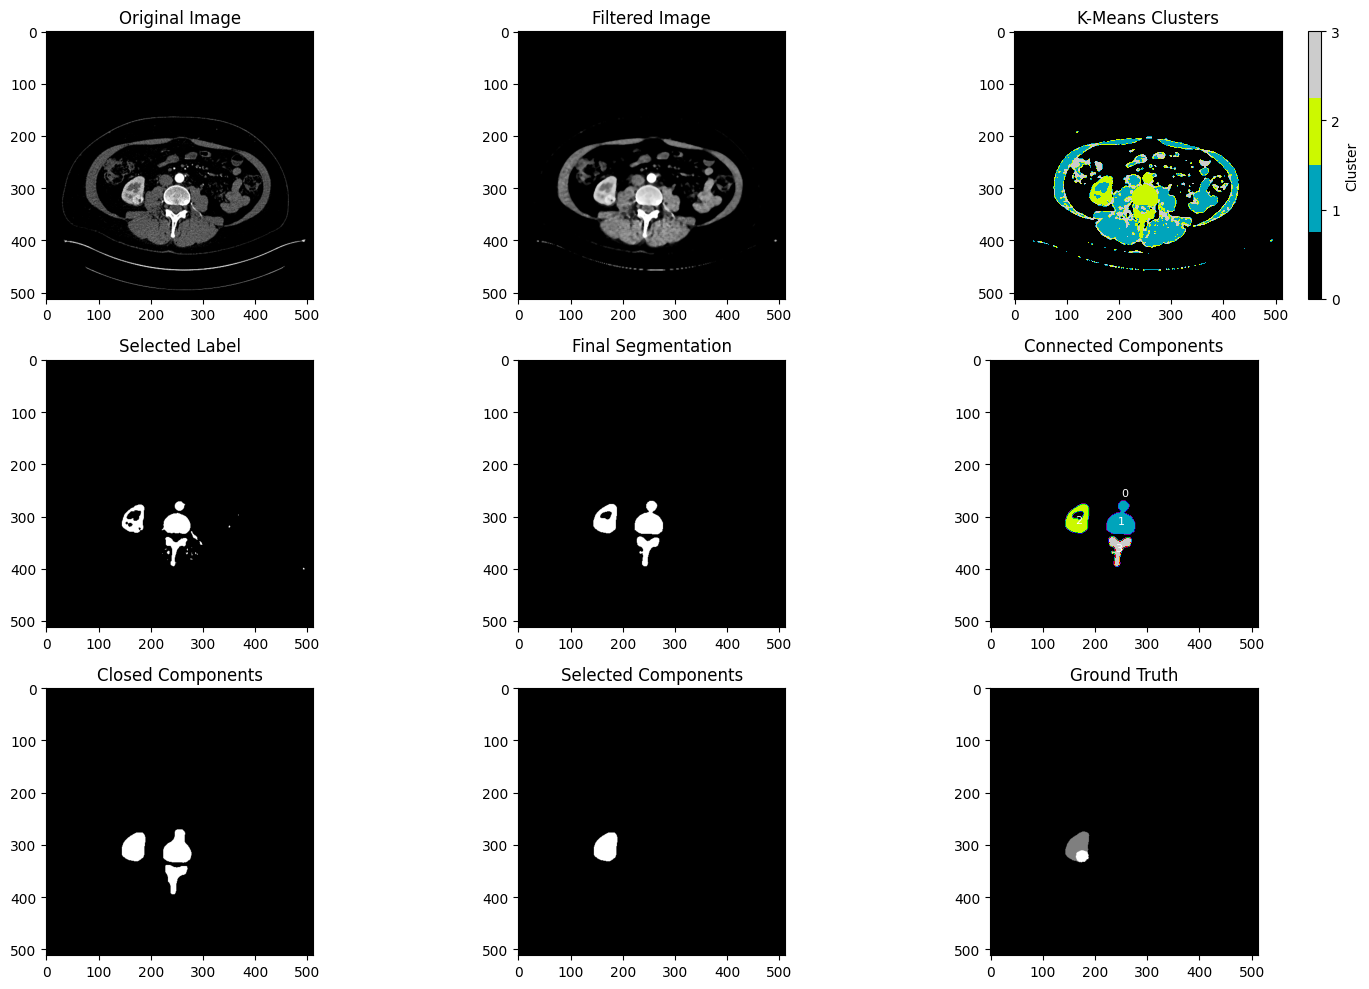

Processing index 3...
Reading image: ./data/abdominalCT_axial\CTs4.tiff
Label values in ground-truth mask image: [  0 127]
The dice score :  0.9524050206385308


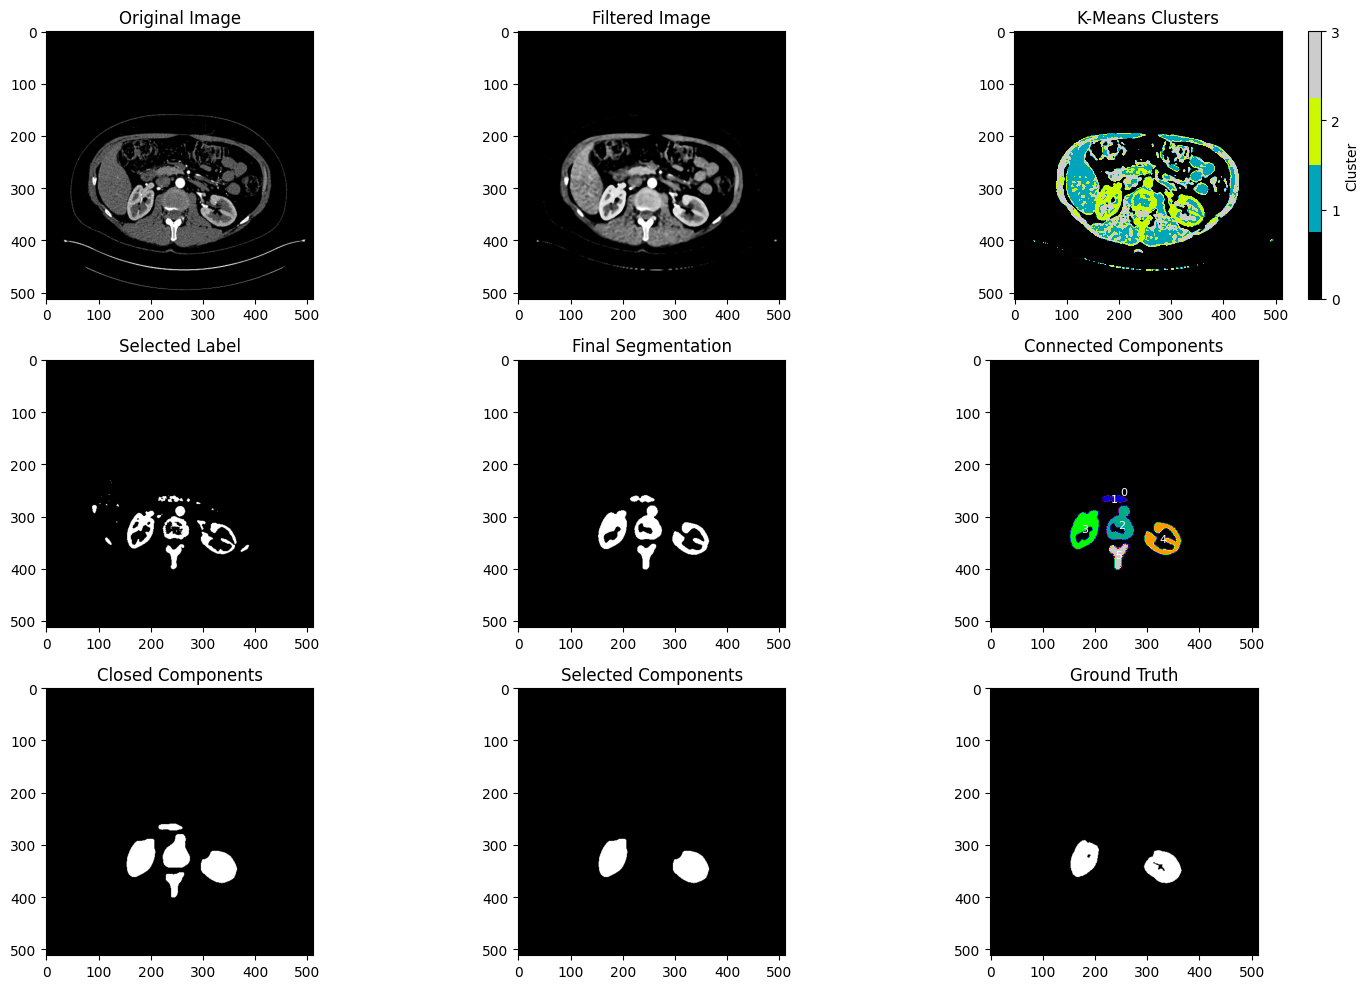

Processing index 4...
Reading image: ./data/abdominalCT_axial\CTs5.tiff
Label values in ground-truth mask image: [  0 127]
The dice score :  0.9720996334804398


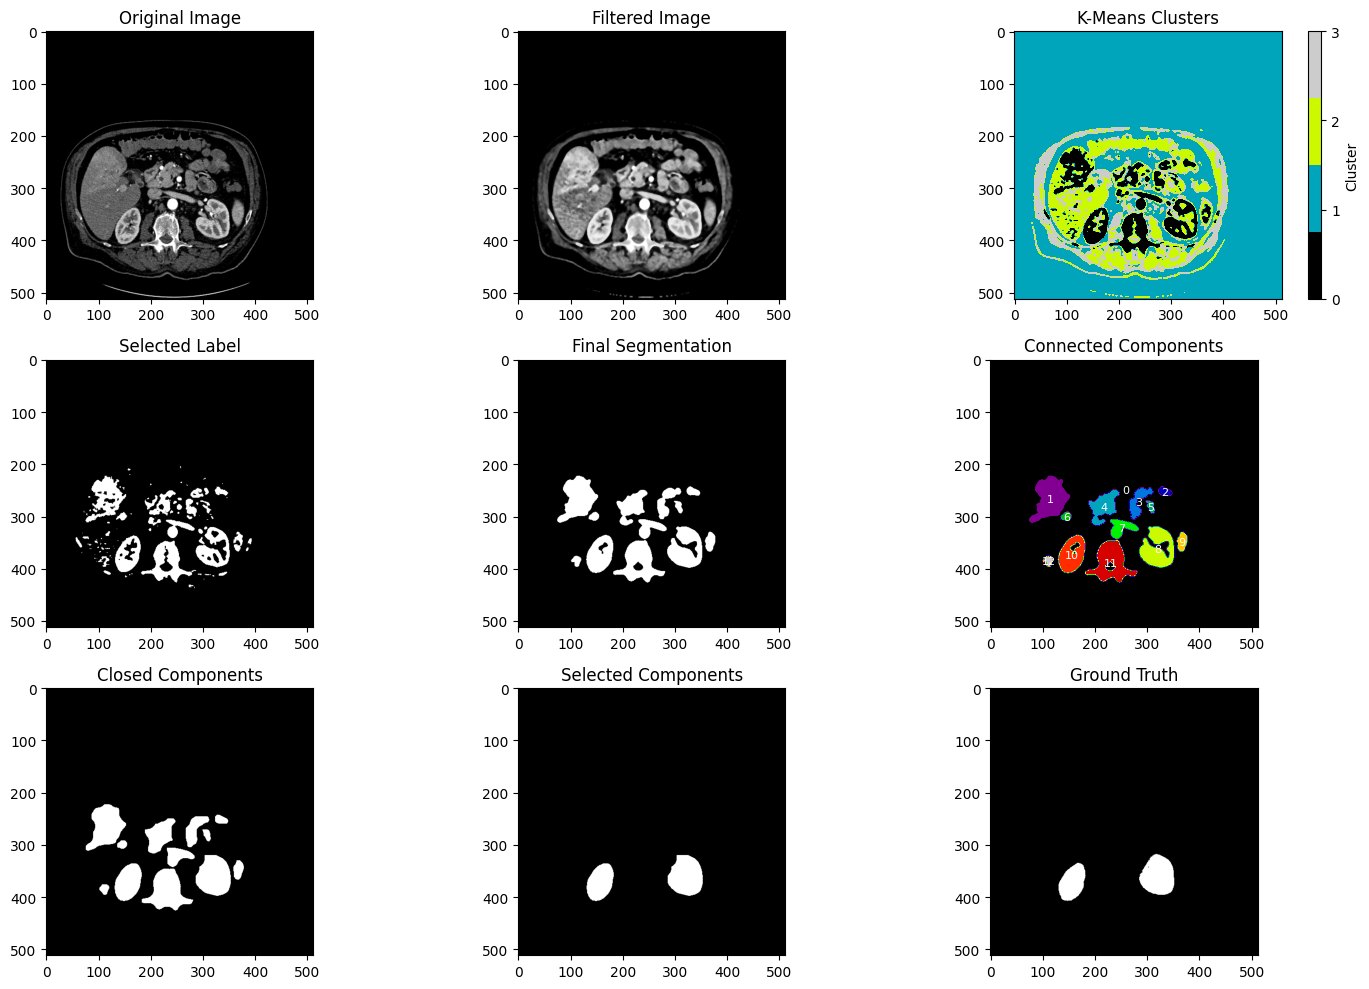

In [17]:
indexes = [1, 3, 4]  # Indexes to process

for indexIm in indexes:
    # Load the image and its segmentation mask
    filename_Segmentation = listImagesabdCT[indexIm]
    Img_seg_gt = imread(filename_Segmentation)  # Ground truth (mask)
    filename = filename_Segmentation[:-9] + '.tiff'
    Img_test = imread(filename)  # Original image

    # Verifications
    print(f'Processing index {indexIm}...')
    print('Reading image:', filename)
    print('Label values in ground-truth mask image:', np.unique(Img_seg_gt))

    if Img_test.shape != Img_seg_gt.shape:
        raise ValueError('Image and mask should have the same shape!')
    
    # Run the segmentation pipeline
    segmentation_pipeline_abdCT(Img_test, Img_seg_gt)

## 3. Implementation of the Pipeline for the Brain MRI


- **Step 1: Preprocessing**
  - Apply median filtering to reduce noise in the input image `img_test`.
  
- **Step 2: K-Means Segmentation**
  - Perform k-means clustering on the filtered image to segment the image into `NBER_CLUSTERS` clusters.

- **Step 3: Compute Mean Pixel Intensity**
  - For each k-means label, calculate the mean pixel intensity in the original image `img_test`.

- **Step 4: Select the Label with Maximum Intensity**
  - Select the cluster label that has the maximum mean intensity.

- **Step 5: Generate Binary Mask for Selected Label**
  - Create a binary mask for the selected label, marking all pixels in the chosen cluster.

- **Step 6: Postprocessing**
  - Apply Gaussian smoothing on the binary mask.
  - Remove small objects and holes using morphological operations.

- **Step 7: Morphological Opening and Closing**
  - Perform morphological opening to remove noise.
  - Follow with closing to fill small gaps in the segmented regions.

- **Step 8: Extract Connected Components**
  - Find and label the connected components in the cleaned image using `cv2.connectedComponentsWithStats`.

- **Step 9: Select the Component with the Lowest Y-Centroid**
  - From the detected connected components, select the component with the lowest centroid Y-coordinate.

In [104]:
# --- Hyperparameters ---
RADIUS = 2                  # Radius for the morphological structuring element (used for basic morphology operations)
NBER_CLUSTERS = 5           # Number of clusters for k-means clustering (determines how the image is segmented)
#TARGET_VALUE_THRESH = 70    # Intensity threshold to target specific pixel ranges for segmentation
GAUSSIAN_SIGMA = 3          # Sigma value for Gaussian smoothing (controls the level of blur applied to smooth edges)
SMOOTH_THRESH = 0.60        # Threshold for binarizing smoothed segmentation results
MIN_SIZE = 200              # Minimum size for connected components to be considered valid
AREA_THRESH = 50            # Minimum area threshold for removing small holes in segmentation
MEDIAN_SIZE = 5             # Size of the kernel for the median filter (used to reduce noise)
RADIUS_OPENING = 2          # Radius for morphological closing (used to smooth the boundaries of connected components)
STRETCH_MIN = 40
STRETCH_MAX = 180
#------------------------

In [101]:
# --- Main Pipeline ---
def segmentation_pipeline_brainMRI(img_test, img_seg_gt):
    """Processes a single example using the segmentation pipeline."""
    
    height, width = img_test.shape[:2]
    roi_height = int(0.6 * height)
    img_test_cropped = img_test[:roi_height, :]
    img_seg_gt_cropped = img_seg_gt[:roi_height, :]
    
    # Step 1 : Preprocessing with noise reduction
    img_filtered = ndimage.median_filter(img_test_cropped, size=MEDIAN_SIZE)
    img_histretch = histogram_stretching(img_filtered, STRETCH_MIN, STRETCH_MAX)
    
    # Step 2 : K-Means Segmentation
    seg_kmeans, seg_labels = my_kmeans(img_histeq, NBER_CLUSTERS)
    colormap = plt.get_cmap('nipy_spectral', NBER_CLUSTERS)

    # Step 3 : Compute mean pixel intensity under each k-means label
    img_label_means = np.empty(NBER_CLUSTERS)
    for i in range(NBER_CLUSTERS):
        img_label_mask = seg_labels == i
        img_label_mask = img_label_mask.astype('uint8')
        img_label_means[i] = cv2.mean(img_test_cropped, img_label_mask)[0]
     
    # Step 4 : Select label with maximum intensity 
    selected_label = np.argmax(img_label_means)

    # Step 5: Generate binary mask for selected label
    img_label_select = (seg_labels == selected_label).astype('float64')

    # Step 6 : Postprocessing
    seg_smooth = gaussian(img_label_select, sigma=GAUSSIAN_SIGMA, preserve_range=True)
    seg_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(seg_smooth > SMOOTH_THRESH, 
                                        min_size=MIN_SIZE), 
        area_threshold=AREA_THRESH)
    
    # Step 7 : Morphological Opening & Closing
    seg_clean_binary = (seg_clean > 0).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (RADIUS_CLOSING, RADIUS_CLOSING))
    img_opened = cv2.morphologyEx(seg_clean_binary, cv2.MORPH_OPEN, kernel)
    img_closed = cv2.morphologyEx(img_opened, cv2.MORPH_CLOSE, kernel) * 255
        
    # Step 8 : Extract connected components
    output = cv2.connectedComponentsWithStats(img_closed.astype(np.uint8))
    (numLabels, labels, stats, centroids) = output
    
    # Step 9 : Select the Component with the Lowest Y-Centroid 
    indices = np.arange(1, len(centroids))  
    lowest_y_idx = min(indices, key=lambda i: centroids[i][1])  
    selected_component = (labels == lowest_y_idx).astype(np.uint8)
    img_output = np.zeros_like(labels, dtype=np.uint8)
    img_output[selected_component > 0] = 255
    
    # Step 10 : Evaluation
    dice_score = calculate_dice(img_output, img_seg_gt_cropped)
    print("The dice score : ", dice_score)

    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img_test_cropped, cmap="gray")
    ax[0].set_title("Original Image")
    
    ax[1].imshow(img_histeq, cmap="gray")
    ax[1].set_title("Filtered Image")
    
    img = ax[2].imshow(seg_labels, cmap=colormap)
    ax[2].set_title("K-Means Clusters")
    cbar = fig.colorbar(img, ax=ax[2], ticks=range(NBER_CLUSTERS))
    cbar.set_label("Cluster")
    
    ax[3].imshow(img_label_select, cmap="gray")
    ax[3].set_title("Selected Label")
    
    ax[4].imshow(img_closed, cmap="gray")
    ax[4].set_title("Final Segmentation")
    
    ax[5].imshow(labels, cmap="nipy_spectral")
    ax[5].set_title("Connected Components")
    for i, centroid in enumerate(centroids):
        ax[5].text(centroid[0], centroid[1], str(i), color="white", fontsize=8, ha="center", va="center") 
    
    ax[6].imshow(img_output, cmap="gray")
    ax[6].set_title("Selected Component")
    
    ax[7].imshow(img_seg_gt, cmap="gray")
    ax[7].set_title("Ground Truth")
    
    ax[8].imshow(img_seg_gt_cropped, cmap="Reds", alpha=0.5)
    ax[8].imshow(img_output, cmap="gray", alpha=0.5)
    ax[8].set_title("Ground Truth & Sel component")
    
    plt.tight_layout()
    plt.show();

In [21]:
brainMRI_path = './data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

There are 4 brain MRI images
['./data/brainMRI\\MRIs1-seg.png', './data/brainMRI\\MRIs2-seg.png', './data/brainMRI\\MRIs3-seg.png', './data/brainMRI\\MRIs4-seg.png']


Reading image  ./data/brainMRI\MRIs1.png
The dice score :  0.0


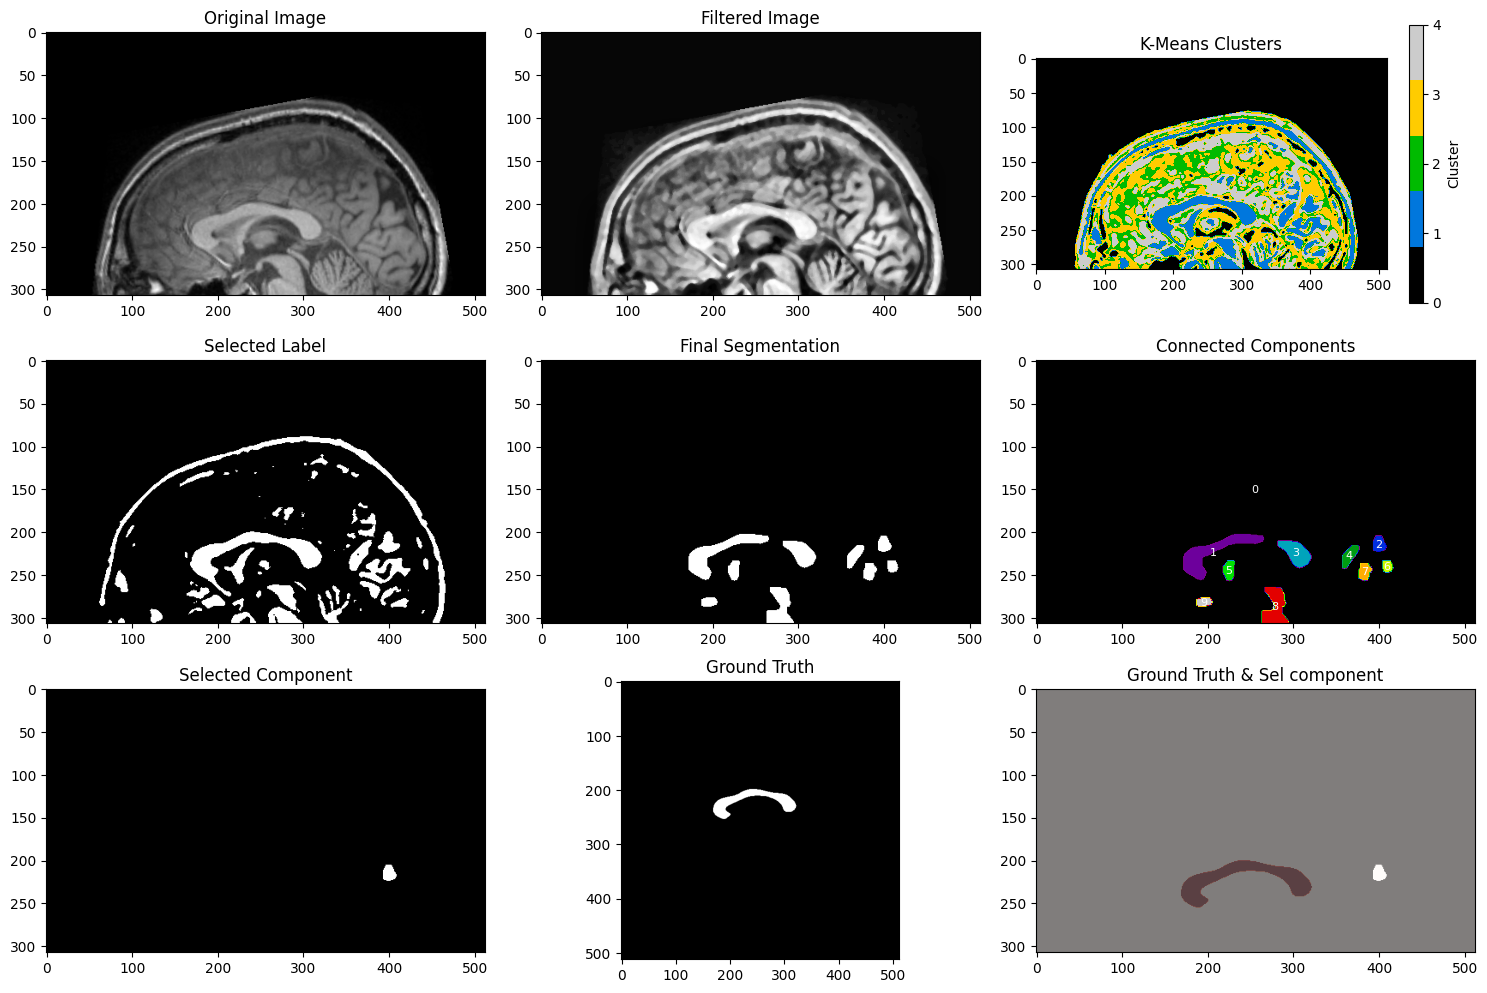

Reading image  ./data/brainMRI\MRIs2.png
The dice score :  0.0


C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\skimage\util\dtype.py:527: UserWarning: Downcasting int32 to uint16 without scaling because max value 48495 fits in uint16
  return _convert(image, np.uint16, force_copy)


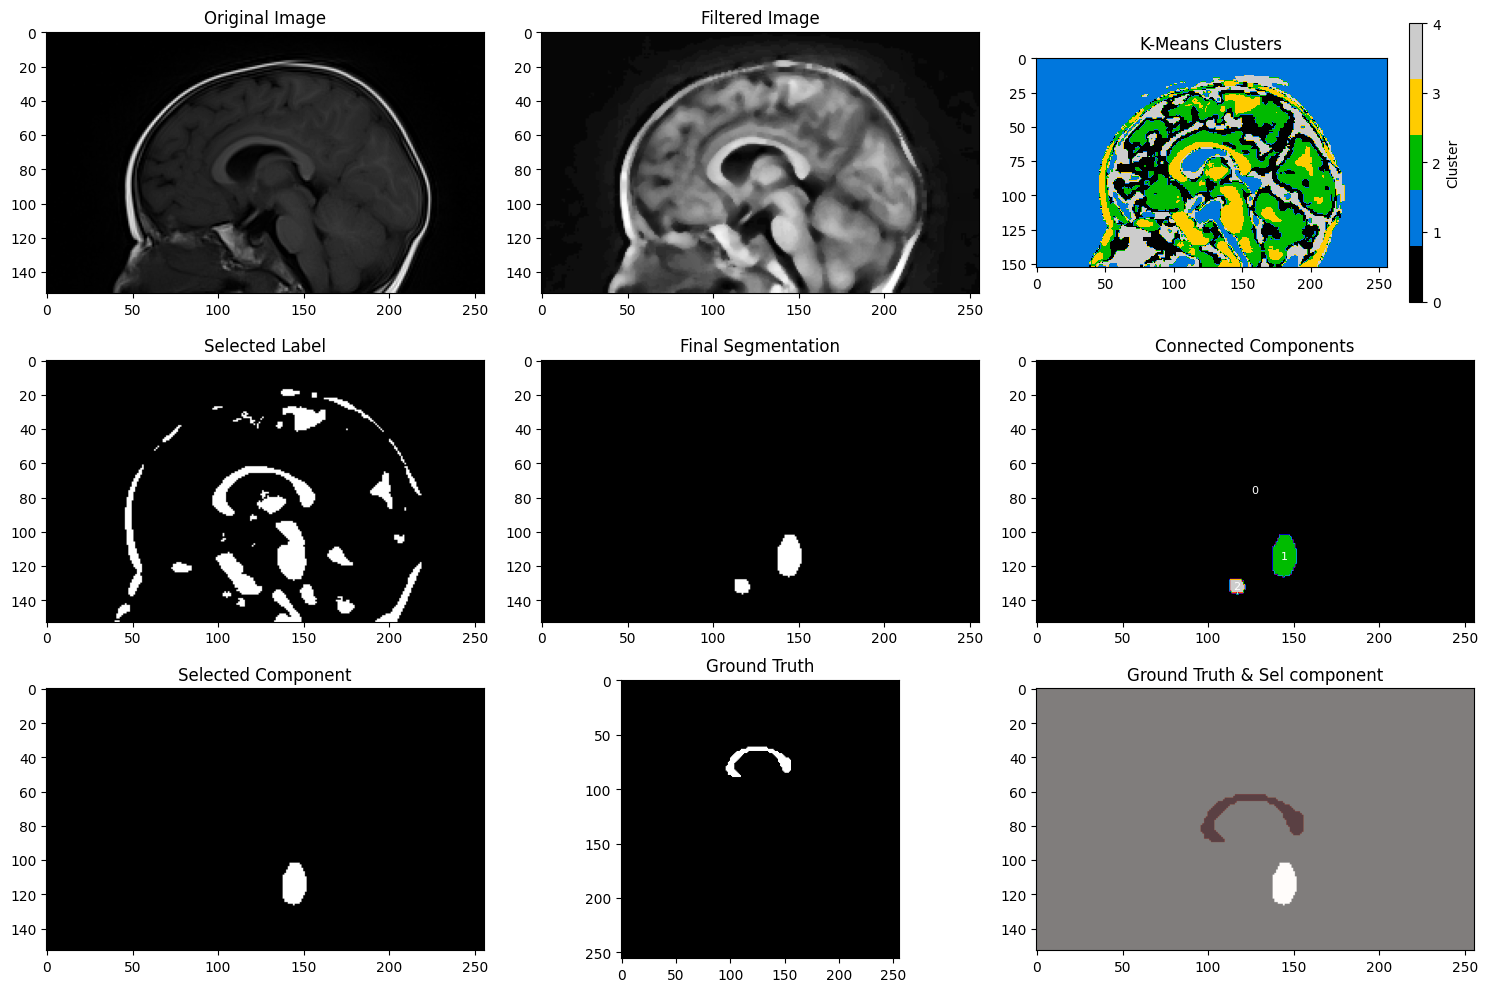

Reading image  ./data/brainMRI\MRIs3.png
The dice score :  0.35901060070671376


C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\skimage\util\dtype.py:527: UserWarning: Downcasting int32 to uint16 without scaling because max value 49441 fits in uint16
  return _convert(image, np.uint16, force_copy)


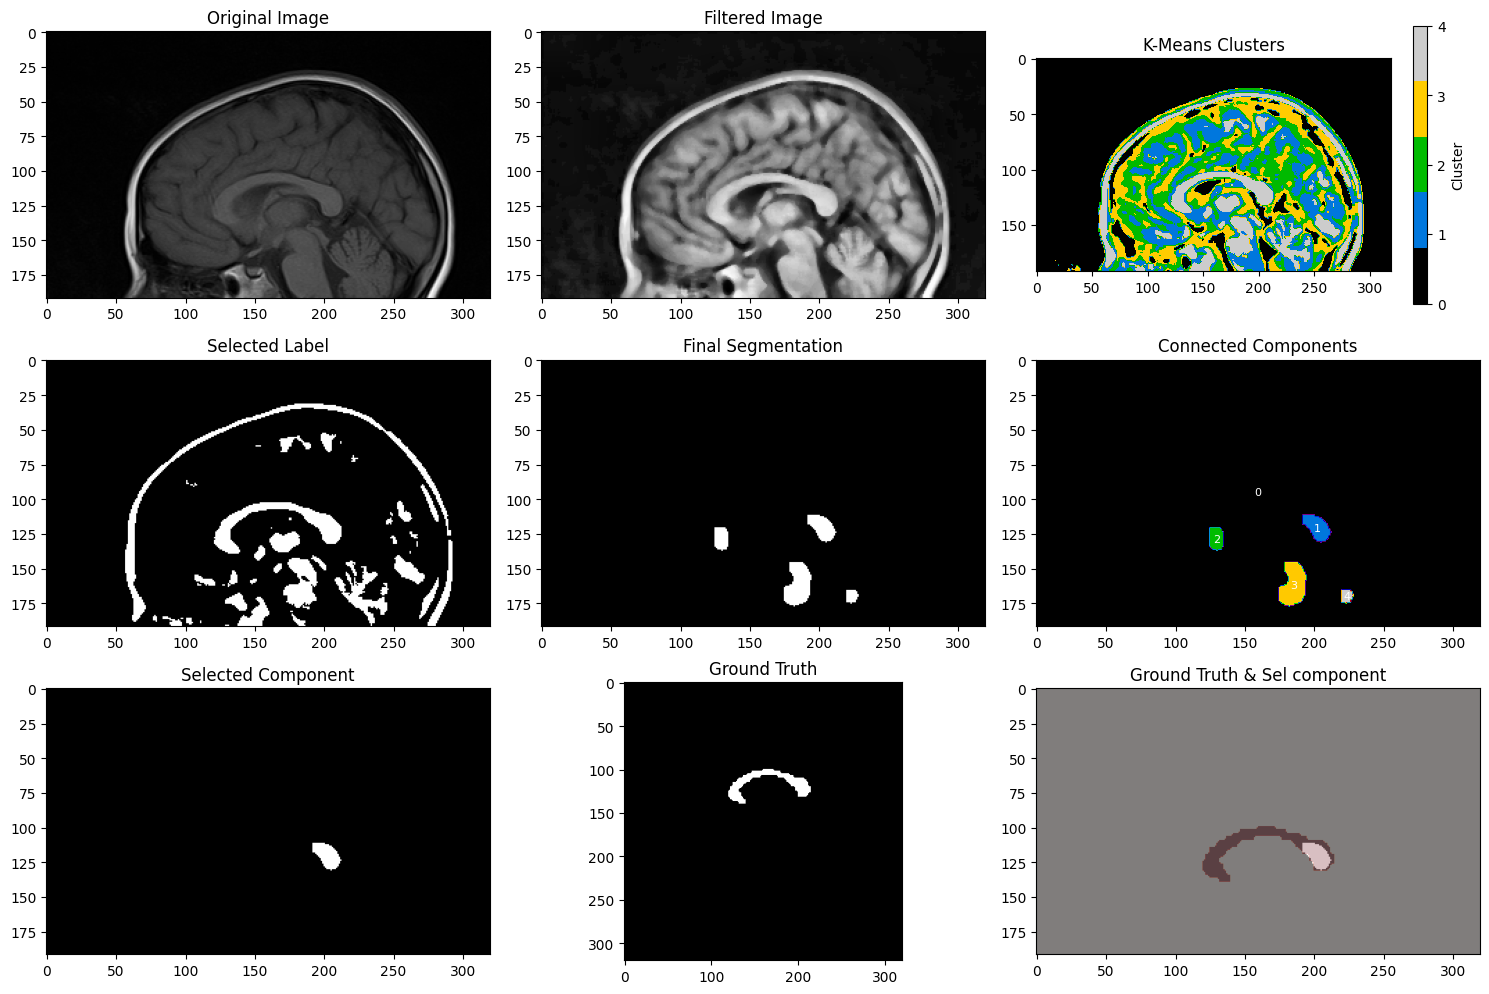

Reading image  ./data/brainMRI\MRIs4.png
The dice score :  0.15377855887521968


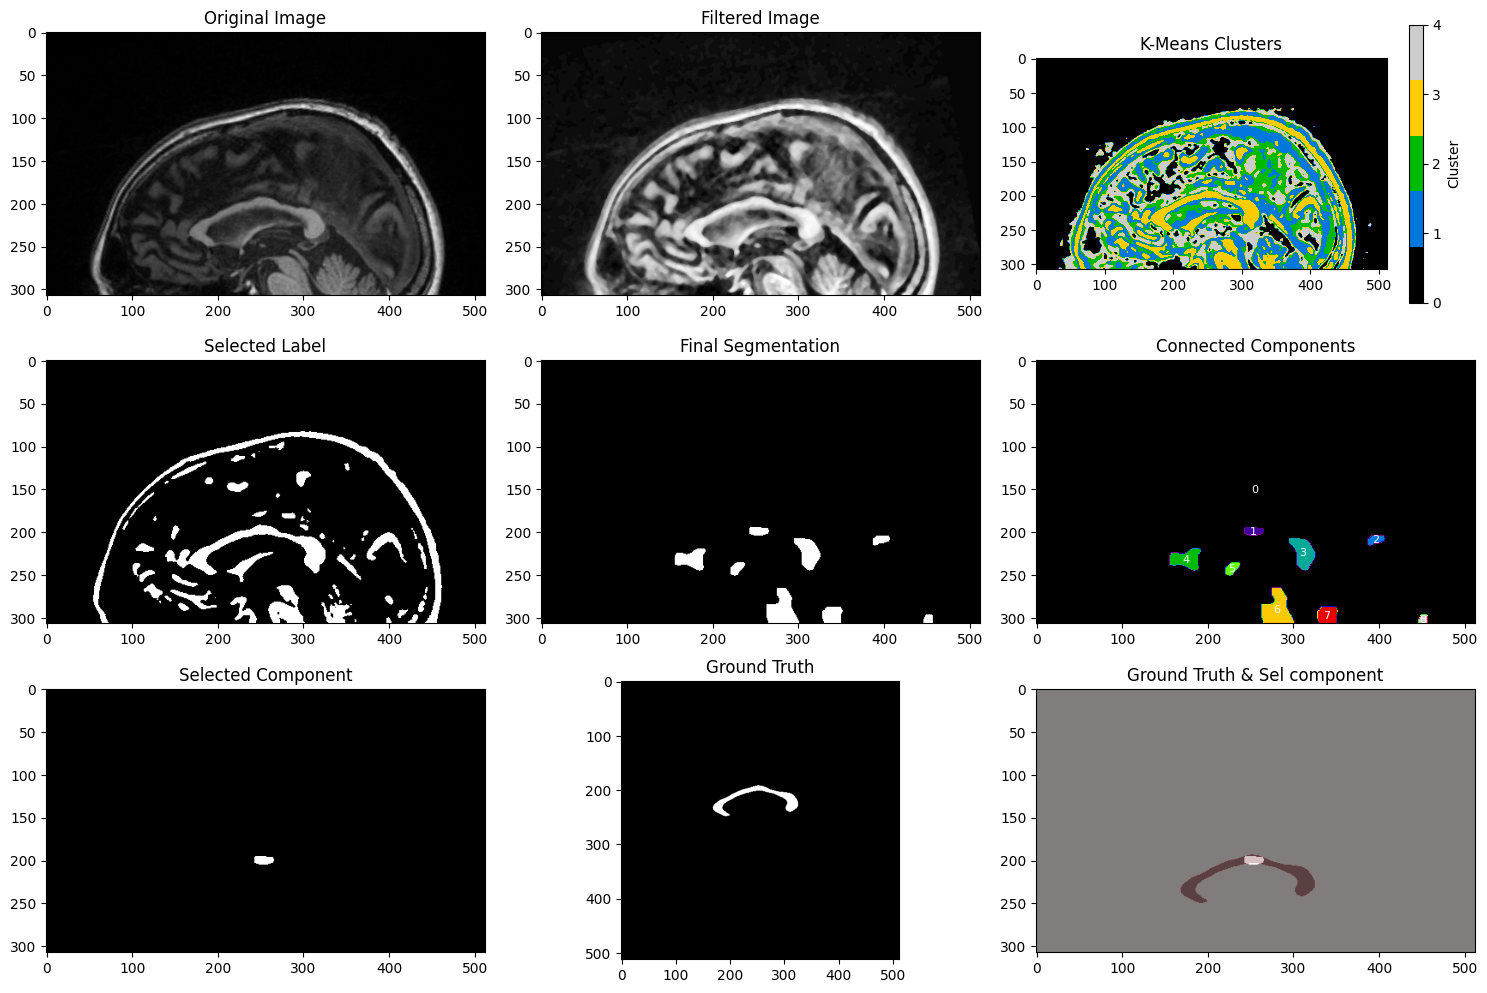

In [102]:
for indexIm in range(4):
    # Construct filenames for the image and the corresponding segmentation mask
    filename_seg = listImagesbrainMRI[indexIm]
    Seg_brain_ex = imread(filename_seg)
    filename = filename_seg[:-8] + '.png'
    Img_brain_ex = imread(filename)

    print('Reading image ', filename)

    # Ensure the image and mask have the same shape
    if Img_brain_ex.shape != Seg_brain_ex.shape:
        raise NameError('Image and mask should have the same shape, problem...')

    # Run the segmentation pipeline on the current image and mask
    segmentation_pipeline_brainMRI(Img_brain_ex, Seg_brain_ex)